## Imports

In [ ]:
!git clone https://github.com/rmnigm/qber-forecasting.git

In [ ]:
!pip install catboost

In [3]:
import collections
import math
import os
import pathlib
import random


import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
import scipy.stats as sps

import statsmodels as sm

from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.kernel_approximation import Nystroem
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import RobustScaler

from tqdm.notebook import tqdm
from xgboost import XGBRegressor

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
seed = 123456
random.seed(seed)
np.random.seed(seed)

## Data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# New Data

In [7]:
import pandas as pd

In [8]:
cols_str = """
| block_id | frame_idx | E_mu_Z | E_mu_phys_est | E_mu_X | E_nu1_X | E_nu2_X| E_nu1_Z | E_nu2_Z |
| N_mu_X | M_mu_XX | M_mu_XZ | M_mu_X |
| N_mu_Z | M_mu_ZZ | M_mu_Z | N_nu1_X | M_nu1_XX | M_nu1_XZ | M_nu1_X | N_nu1_Z | M_nu1_ZZ | M_nu1_Z |
| N_nu2_X | M_nu2_XX | M_nu2_XZ | M_nu2_X | N_nu2_Z | M_nu2_ZZ | M_nu2_Z |
| nTot | bayesImVoltage | opticalPower | polarizerVoltages[0] | polarizerVoltages[1] | polarizerVoltages[2] | polarizerVoltages[3] |
| temp_1 | biasVoltage_1 | temp_2 | biasVoltage_2 | synErr |
| N_EC_rounds | maintenance_flag | estimator_name | f_EC | E_mu_Z_est | R | s | p
"""

columns = list(filter(lambda x: x, cols_str.replace(' ', '').replace('\n', '').split('|')))

In [9]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/qber/frames_errors_hw_info_2.csv', header=None)

In [10]:
df.columns = columns

In [11]:
interesting_columns = columns[2:41]

In [12]:
from tqdm.auto import tqdm, trange

def build_sliding_windows(data, window_size=20):
    total_len = len(data)
    windows = []
    targets = []
    for start_index in trange(total_len - window_size - 1):
        end_index = start_index + window_size
        target_index = end_index + 1
        window = data.iloc[start_index:end_index]
        target = data.iloc[target_index]
        windows.append(window)
        targets.append(target)
    return windows, targets

In [ ]:
data = df[interesting_columns]
data["index"] = data.index
window_size = 50

In [ ]:
import plotly.express as px

fig = px.line(data, x="index", y=["E_mu_Z", "E_mu_X"])
fig.show()

<Axes: xlabel='index', ylabel='polarizerVoltages[0]'>

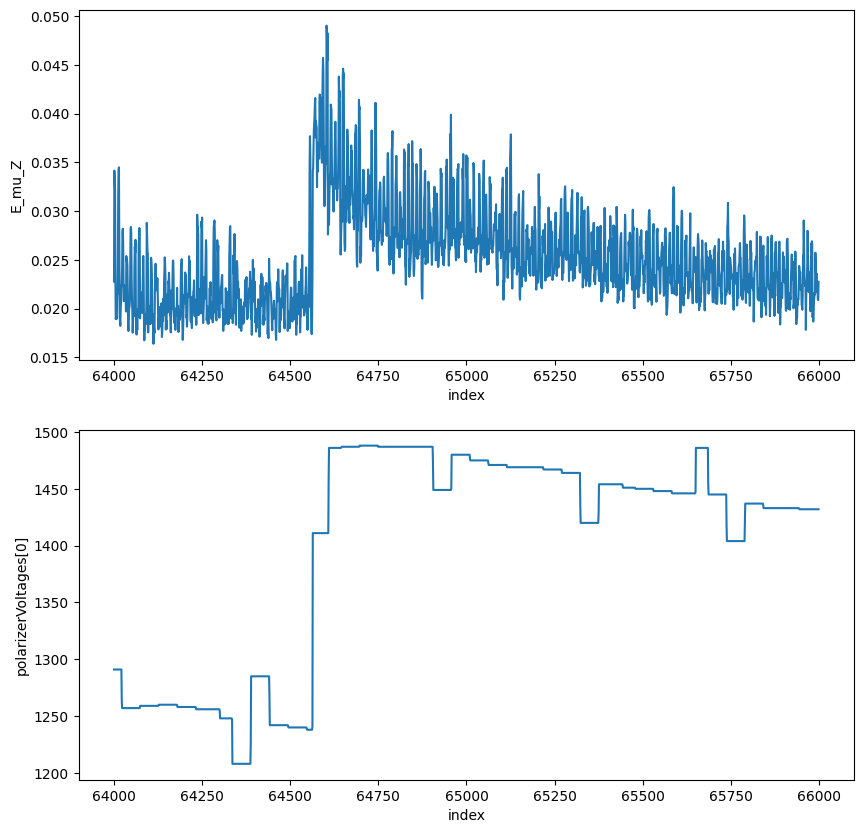

In [92]:
fig, axes = plt.subplots(nrows=2, figsize=(10, 10))

subset = data[64000:66000]

sns.lineplot(subset, x="index", y="E_mu_Z", ax=axes[0])
sns.lineplot(subset, x="index", y="polarizerVoltages[0]", ax=axes[1])

In [52]:
# windows, targets = build_sliding_windows(data, window_size)

  0%|          | 0/328566 [00:00<?, ?it/s]

In [14]:
import warnings

In [40]:
n_lags = 10

dataset = data.copy()[165000:]
dataset = dataset.drop(columns='nTot')
variable_names = dataset.columns
variable_names = list(filter(lambda x: x != 'E_mu_Z', variable_names))

dataset['target'] = dataset['E_mu_Z'].shift(-1)

for i in range(1, n_lags):
    dataset[f'lag_{i + 1}_E_mu_Z'] = dataset['E_mu_Z'].shift(i)

for ws in [5, 10, 20, 30, 60]:
    roll_mean = dataset[variable_names].rolling(window=ws).mean()
    roll_std = dataset[variable_names].rolling(window=ws).std()
    dataset = dataset.join(roll_mean, rsuffix=f'_{ws}_rolling_mean')
    dataset = dataset.join(roll_std, rsuffix=f'_{ws}_rolling_std')

dataset = dataset.join(dataset[variable_names].ewm(alpha=0.33).mean(), rsuffix=f'_ewm33_mean')
dataset = dataset.join(dataset[variable_names].ewm(alpha=0.33).std(), rsuffix=f'_ewm33_std')
dataset = dataset.join(dataset[variable_names].ewm(alpha=0.5).mean(), rsuffix=f'_ewm50_mean')
dataset = dataset.join(dataset[variable_names].ewm(alpha=0.5).std(), rsuffix=f'_ewm50_std')

dataset = dataset.join(dataset[variable_names].shift(1), rsuffix=f'_latest_value')

dataset = dataset.dropna()


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for var in filter(lambda x: x != 'E_mu_Z', variable_names):
        dataset[f"{var}_ewm33_diff"] = dataset[f"{var}_latest_value"] / dataset[f"{var}_ewm33_mean"]
        dataset[f"{var}_ewm50_diff"] = dataset[f"{var}_latest_value"] / dataset[f"{var}_ewm50_mean"]
        dataset[f"{var}_5_rolling_diff"] = dataset[f"{var}_latest_value"] / dataset[f"{var}_5_rolling_mean"]
        dataset[f"{var}_30_rolling_diff"] = dataset[f"{var}_latest_value"] / dataset[f"{var}_30_rolling_mean"]
        dataset[f"{var}_60_rolling_diff"] = dataset[f"{var}_latest_value"] / dataset[f"{var}_60_rolling_mean"]

    dataset = dataset.drop(columns=variable_names)
    dataset['lag_1_E_mu_Z'] = dataset['E_mu_Z']
    dataset = dataset.drop(columns='E_mu_Z')
    dataset = dataset.fillna(0)
    dataset = dataset.copy()

In [42]:
dataset.shape

(163557, 751)

In [43]:
def extract_window_statistics(window):
    features = []
    feature_names = []
    names = list(window.columns)

    features += list(window['E_mu_Z'])
    feature_names += [f'lag_{i}' for i in range(1, len(window) + 1)][::-1]

    for ws in [5, 10, 20, 30]:
        roll = window.rolling(window=ws)
        features += list(roll.mean().iloc[-1])
        feature_names += [f"{n}_window_{ws}_mean" for n in names]
        features += list(roll.std().iloc[-1])
        feature_names += [f"{n}_window_{ws}_std" for n in names]

    features += list(window.mean())
    feature_names += [f"{n}_window_full_mean" for n in names]
    features += list(window.std())
    feature_names += [f"{n}_window_full_mean" for n in names]


    features += list(window.ewm(alpha=0.33).mean().iloc[-1])
    feature_names += [f"{n}_ewm_033_mean" for n in names]
    features += list(window.ewm(alpha=0.5).mean().iloc[-1])
    feature_names += [f"{n}_ewm_050_mean" for n in names]

    features += list(window.ewm(alpha=0.33).std().iloc[-1])
    feature_names += [f"{n}_ewm_033_std" for n in names]
    features += list(window.ewm(alpha=0.5).std().iloc[-1])
    feature_names += [f"{n}_ewm_050_std" for n in names]

    return dict(zip(feature_names, features))


def extract_target(target):
    target_value = target['E_mu_Z']
    latest = target.drop('E_mu_Z')
    latest_values = list(latest)
    latest_names = list(latest.index)
    return target_value, dict(zip(latest_names, latest_values))


def extract_diff_features(features, columns):
    for col in columns:
        features[f"{col}_window_5_diff"] = features[col] - features[f"{col}_window_5_mean"]
        features[f"{col}_window_10_diff"] = features[col] - features[f"{col}_window_10_mean"]
        features[f"{col}_window_full_diff"] = features[col] - features[f"{col}_window_full_mean"]
        features[f"{col}_ewm_033_diff"] = features[col] - features[f"{col}_ewm_033_mean"]
    return features


def extract_features_with_target(window, target):
    f = extract_window_statistics(window)
    t, lf = extract_target(target)
    f |= lf
    extract_diff_features(f, lf.keys())
    return f, t

In [44]:
X = dataset.drop(columns='target')
y = dataset['target']

In [18]:
from sklearn.linear_model import Ridge, Lasso

model = Ridge(max_iter=4000)

model.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.03253e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge(max_iter=4000)

## Modelling

In [22]:
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
from catboost import EShapCalcType, EFeaturesSelectionAlgorithm

model = CatBoostRegressor(
    learning_rate=0.05,
    early_stopping_rounds=100,
    task_type='GPU',
    devices='0'
    )

summary = model.select_features(
    X_train, y_train,
    eval_set=(X_test, y_test),
    features_for_select='0-749',
    num_features_to_select=100,
    steps=5,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    verbose=False,
    plot=True
)

In [55]:
from sklearn.metrics import r2_score

In [56]:
preds = model.predict(X_train)
print(r2_score(y_train, preds))

preds = model.predict(X_test)
print(r2_score(y_test, preds))

0.8545961204846082
0.7944110277690408


In [67]:
selected_features = summary["selected_features_names"]

In [69]:
model = CatBoostRegressor(
    learning_rate=0.05,
    iterations=5000,
    early_stopping_rounds=100,
    task_type='GPU',
    devices='0'
    )


model.fit(X_train[selected_features], y_train,
          eval_set=(X_test[selected_features], y_test)
          )

preds = model.predict(X_train)
print(r2_score(y_train, preds))

preds = model.predict(X_test)
print(r2_score(y_test, preds))

0:	learn: 0.0043007	test: 0.0037832	best: 0.0037832 (0)	total: 25.1ms	remaining: 2m 5s
1:	learn: 0.0041945	test: 0.0036707	best: 0.0036707 (1)	total: 49.2ms	remaining: 2m 2s
2:	learn: 0.0040834	test: 0.0035574	best: 0.0035574 (2)	total: 73.2ms	remaining: 2m 1s
3:	learn: 0.0039933	test: 0.0034557	best: 0.0034557 (3)	total: 97.3ms	remaining: 2m 1s
4:	learn: 0.0039133	test: 0.0033660	best: 0.0033660 (4)	total: 113ms	remaining: 1m 52s
5:	learn: 0.0038323	test: 0.0032775	best: 0.0032775 (5)	total: 124ms	remaining: 1m 43s
6:	learn: 0.0037559	test: 0.0031977	best: 0.0031977 (6)	total: 134ms	remaining: 1m 35s
7:	learn: 0.0036768	test: 0.0031217	best: 0.0031217 (7)	total: 149ms	remaining: 1m 32s
8:	learn: 0.0036110	test: 0.0030443	best: 0.0030443 (8)	total: 176ms	remaining: 1m 37s
9:	learn: 0.0035472	test: 0.0029793	best: 0.0029793 (9)	total: 198ms	remaining: 1m 38s
10:	learn: 0.0034872	test: 0.0029158	best: 0.0029158 (10)	total: 209ms	remaining: 1m 34s
11:	learn: 0.0034339	test: 0.0028527	best

In [83]:
importance = pd.DataFrame({"features": model.feature_names_, "importance": model.feature_importances_})
importance.sort_values(by="importance", ascending=False).head(30)

,features,importance
99,lag_1_E_mu_Z,39.312563
6,lag_10_E_mu_Z,7.604430
0,lag_2_E_mu_Z,5.987934
1,lag_3_E_mu_Z,4.485459
2,lag_4_E_mu_Z,3.975117
5,lag_9_E_mu_Z,3.774431
4,lag_8_E_mu_Z,3.565922
34,E_mu_phys_est_60_rolling_std,3.012587
35,E_mu_X_60_rolling_std,2.524986
3,lag_6_E_mu_Z,2.414365


In [72]:
importance.to_csv("/content/drive/MyDrive/Datasets/qber/useful_features.csv")

In [81]:
temp = pd.DataFrame({
    "prediction": preds,
    "ground_truth": y_test,
    "index": range(len(preds)),
})

temp.to_csv("predictions.csv")

In [80]:
import plotly.express as px

fig = px.line(temp, x="index", y=["prediction", "ground_truth"])
fig.show()